<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter12/Handwritten_digit_generation_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Lab, we will use GAN to generate handwritten digits.

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.utils import make_grid

     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 78 kB 5.1 MB/s 
     |████████████████████████████████| 58 kB 4.7 MB/s 
     |████████████████████████████████| 235 kB 57.5 MB/s 
     |████████████████████████████████| 1.6 MB 55.3 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 


In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

data_loader = torch.utils.data.DataLoader(MNIST('~/data', train=True, download=True, transform=transform),batch_size=128, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.model(x)

In [ ]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,784))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                803,840
|    └─LeakyReLU: 2-2                    [-1, 1024]                --
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─LeakyReLU: 2-5                    [-1, 512]                 --
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─LeakyReLU: 2-8                    [-1, 256]                 --
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                803,840
|    └─LeakyReLU: 2-2                    [-1, 1024]                --
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─LeakyReLU: 2-5                    [-1, 512]                 --
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─LeakyReLU: 2-8                    [-1, 256]                 --
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable par

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x): return self.model(x)

In [ ]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 256]                 25,856
|    └─LeakyReLU: 2-2                    [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 512]                 131,584
|    └─LeakyReLU: 2-4                    [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 1024]                525,312
|    └─LeakyReLU: 2-6                    [-1, 1024]                --
|    └─Linear: 2-7                       [-1, 784]                 803,600
|    └─Tanh: 2-8                         [-1, 784]                 --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 2.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.67
Estimated Total Size (MB): 5.69


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 256]                 25,856
|    └─LeakyReLU: 2-2                    [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 512]                 131,584
|    └─LeakyReLU: 2-4                    [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 1024]                525,312
|    └─LeakyReLU: 2-6                    [-1, 1024]                --
|    └─Linear: 2-7                       [-1, 784]                 803,600
|    └─Tanh: 2-8                         [-1, 784]                 --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 2.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.67
Estimated Total Size (MB): 5.69

In [ ]:
def noise(size):
    n = torch.randn(size, 100)
    return n.to(device)

In [ ]:
# Define a function to train the discriminator
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    # When we calculate the discriminator loss on real data, we expect the discriminator to predict an output of 1    
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    # When we calculate the discriminator loss on fake data, we expect the discriminator to predict an output of 0. 
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

In [ ]:
def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    # When training the generator, we want to fool the discriminator to output a value of 1 for generated /fake img
    error = loss(prediction, torch.ones(len(real_data), 1).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()
num_epochs = 200
log = Report(num_epochs)

EPOCH: 1.000	d_loss: 0.978	g_loss: 2.453	(1217.40s - 242262.01s remaining)
EPOCH: 2.000	d_loss: 1.112	g_loss: 1.634	(1230.08s - 121777.71s remaining)
EPOCH: 3.000	d_loss: 1.166	g_loss: 1.362	(1242.66s - 81601.31s remaining)
EPOCH: 4.000	d_loss: 1.149	g_loss: 1.672	(1255.25s - 61507.02s remaining)
EPOCH: 5.000	d_loss: 0.986	g_loss: 1.609	(1267.84s - 49445.84s remaining)
EPOCH: 6.000	d_loss: 0.883	g_loss: 1.930	(1280.42s - 41400.21s remaining)
EPOCH: 7.000	d_loss: 0.926	g_loss: 1.694	(1292.92s - 35647.78s remaining)
EPOCH: 8.000	d_loss: 0.883	g_loss: 1.823	(1305.59s - 31334.06s remaining)
EPOCH: 9.000	d_loss: 0.928	g_loss: 1.759	(1318.89s - 27989.72s remaining)
EPOCH: 10.000	d_loss: 0.917	g_loss: 1.654	(1331.40s - 25296.57s remaining)
EPOCH: 11.000	d_loss: 0.935	g_loss: 1.659	(1343.85s - 23089.71s remaining)
EPOCH: 12.000	d_loss: 0.974	g_loss: 1.520	(1356.28s - 21248.37s remaining)
EPOCH: 13.000	d_loss: 0.966	g_loss: 1.576	(1368.98s - 19692.24s remaining)
EPOCH: 14.000	d_loss: 0.994	g_lo

100%|██████████| 301/301 [00:14<00:00, 20.78it/s]


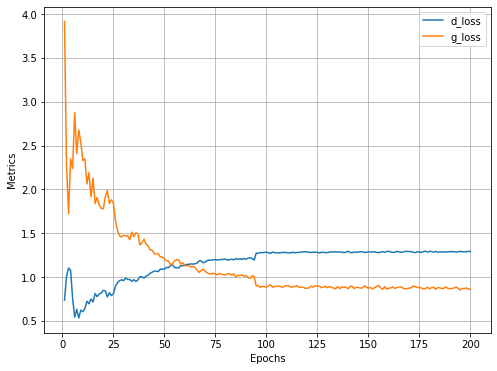

In [ ]:
for epoch in range(num_epochs):
    N = len(data_loader)
    for i, (images, _) in enumerate(data_loader):
        real_data = images.view(len(images), -1).to(device)
        fake_data = generator(noise(len(real_data))).to(device)        
        fake_data = fake_data.detach()# It is import to detach fake data, so that when we are training discriminator, the generate is freezed (i.e. no weights update)
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(noise(len(real_data))).to(device)#generate new fake data and this time only train the generator
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss', 'g_loss'])

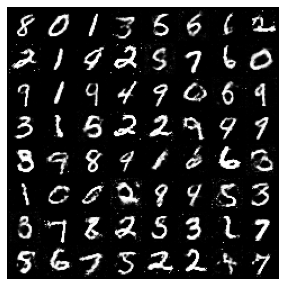

In [ ]:
z = torch.randn(64, 100).to(device)
sample_images = generator(z).data.cpu().view(64, 1, 28, 28)
grid = make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=5)

From this, we can see that we can leverage GANs to generate images that are realistic, but still with some scope for improvement. 